In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import shutil

import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import LongTensor, FloatTensor
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

import utils

/Users/mzmeev/miniconda3/envs/pytorch/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
P_RAW_TEXTS = './data/raw_text.txt'
P_FILE_IDXES = 'data/file_idxes.npy'
P_TOKENIZER = 'data/tokenizer.pickle'
P_LABEL2IDX = 'data/label2idx.pickle'
P_LABEL_COUNTER = 'data/label_counter.pickle'
P_WORD_VECTORS = 'data/word_vectors.txt'
P_DATA = './data'
FIELDS_DELIMETR = '\t\t'
LABELS_DELIMETR = '##'

In [4]:
EMBEDDING_DIM = 200

In [5]:
label2idx = utils.unpickle_obj(P_LABEL2IDX)
label_counter = utils.unpickle_obj(P_LABEL_COUNTER)
tokenizer = utils.unpickle_obj(P_TOKENIZER)
file_idxes = np.load(P_FILE_IDXES)

In [6]:
for bx, by in utils.iterate_batches(file_idxes, tokenizer, label2idx, P_DATA):
    print(len(bx), len(by))
    break

10 10


In [7]:
len(tokenizer.word_count)

3000

In [8]:
word_vectors = utils.merge_with_pretrained(tokenizer, P_WORD_VECTORS, EMBEDDING_DIM)

In [9]:
len(tokenizer.word_count)

2007

In [10]:
word_vectors.shape

(2008, 200)

    Make Dataset instance and define model

In [11]:
class TextsDataset(Dataset):
    def __init__(self, file_idxes, data_path, label2idx):
        self.file_idxes = file_idxes
        self.data_path = data_path
        self.label2idx = label2idx
        
    def __len__(self):
        return len(self.file_idxes)
    
    def _make_path(self, idx):
        return utils.get_dir_path(
            shutil.os.path.join(P_DATA, 'len' + str(file_idxes[idx, 0])),
            *map(str, file_idxes[idx, 1:]))
    
    def __getitem__(self, idx):
        batch_x, batch_labels = utils.read_batch(self._make_path(idx))
        batch_x = [tokenizer.tokenize(t) for t in batch_x]
        batch_labels = [utils.map_labels(ll, self.label2idx) for ll in batch_labels]
        batch_y = np.zeros([len(batch_labels), len(self.label2idx)], 'int32')
        for i, ll in enumerate(batch_labels):
            batch_y[i, ll] = 1
        batch_x = pad_sequences(batch_x)
        return Variable(LongTensor(batch_x)), Variable(FloatTensor(batch_y))

In [12]:
class ConvClassifier(nn.Module):
    def __init__(self, kernel_size, n_filters, embedding_dim, word_vectors, n_labels, freeze_embeds=True):
        super(ConvClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(word_vectors, freeze_embeds)
        self.conv = nn.Conv2d(1, n_filters, [kernel_size, embedding_dim])
        self.linear = nn.Linear(n_filters, n_labels)
        
    def forward(self, batch_in):
        batch_in = torch.unsqueeze(batch_in, 1)
        print(batch_in.size())
        x = self.embedding(batch_in)
        print(x.size())
        x = self.conv(x)
        print(x.size())
        x = torch.squeeze(x, -1)
        print(x.size())
        x = nn.MaxPool1d(x.size()[2])(x)
        print(x.size())
        x = torch.squeeze(x, 2)
        print(x.size())
        logits = self.linear(x)
        return logits

    Init model and dataloader and train

In [13]:
dataset = TextsDataset(file_idxes, P_DATA, label2idx)
dataloader = DataLoader(dataset, num_workers=1, collate_fn=lambda l: l[0])
clf = ConvClassifier(2, 10, 200, FloatTensor(word_vectors), len(label2idx))
optimizer = Adam(filter(lambda p: p.requires_grad, clf.parameters()))
criterion = nn.BCEWithLogitsLoss()

for batch_x, batch_y in dataloader:
    logits = clf(batch_x)
    loss = criterion(logits, batch_y)
    print(float(loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    break

torch.Size([10, 1, 26])
torch.Size([10, 1, 26, 200])
torch.Size([10, 10, 25, 1])
torch.Size([10, 10, 25])
torch.Size([10, 10, 1])
torch.Size([10, 10])
0.7444115281105042


    Check batch_normalization

In [100]:
import tensorflow as tf

In [101]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)


Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [117]:
def batch_gen(data, labels, batch_size):
    while True:
        idxes = np.arange(len(data))
        np.random.shuffle(idxes)
        for start_idx in range(0, len(data), batch_size):
            end_idx = min(start_idx + batch_size, len(data))
            yield FloatTensor(data[start_idx : end_idx]), LongTensor(labels[start_idx : end_idx])

In [189]:
class MnistTestModel(nn.Module):
    def __init__(self, use_bn):
        super(MnistTestModel, self).__init__()
        self.use_bn = use_bn
        self.linear1 = nn.Linear(784, 100, bias=not use_bn)
        self.linear2 = nn.Linear(100, 100, bias=not use_bn)
        if self.use_bn:
            self.batch_norm = nn.BatchNorm1d(100, 1e-3, 0.01)
        
        self.linear_out = nn.Linear(100, 10)
        
    def forward(self, batch_x):
        x = self.linear1(batch_x)
        x = self.linear2(x)
        if self.use_bn:
            x = self.batch_norm(x)
        x = self.linear_out(x)
        return nn.functional.log_softmax(x, dim=1)

In [190]:
model_bn = MnistTestModel(True)
model_nbn = MnistTestModel(False)
criterion = nn.NLLLoss()
optimizer_bn = Adam(model_bn.parameters(), lr=0.01)
optimizer_nbn = Adam(model_nbn.parameters(), lr=0.01)



In [191]:
%%time

tn_losses_bn = []
eval_losses_bn = []
tn_losses_nbn = []
eval_losses_nbn = []

tn_accs_bn = []
eval_accs_bn = []
tn_accs_nbn = []
eval_accs_nbn = []

train_gen = batch_gen(train_data, train_labels, 60)
eval_gen = batch_gen(eval_data, eval_labels, 100)

for i in tqdm_notebook(range(1, 10001)):

    batch_x, batch_y = next(train_gen)

    lbn, abn = step(model_bn, batch_x, batch_y, optimizer_bn)
    lnbn, anbn = step(model_nbn, batch_x, batch_y, optimizer_nbn)

    tn_losses_bn.append(lbn)
    tn_losses_nbn.append(lnbn)
    tn_accs_bn.append(abn)
    tn_accs_nbn.append(anbn)

    if i % 500 == 0:
        model_bn.eval()
        model_nbn.eval()

        full_loss_bn, full_right_bn = 0, 0
        full_loss_nbn, full_right_nbn = 0, 0
        fake_full_loss_bn, fake_full_right_bn = 0, 0

        for _ in range(100):
            batch_x, batch_y = next(eval_gen)
            lbn, abn = step(model_bn, batch_x, batch_y)
            lnbn, anbn = step(model_nbn, batch_x, batch_y)

            full_loss_bn += lbn
            full_right_bn += 100 * abn

            full_loss_nbn += lnbn
            full_right_nbn += 100 * anbn

        eval_losses_bn.append(full_loss_bn / 100)
        eval_losses_nbn.append(full_loss_nbn / 100)
        eval_accs_bn.append(full_right_bn / 10000)
        eval_accs_nbn.append(full_right_nbn / 10000)
        
        model_bn.train()
        model_nbn.train()


CPU times: user 3min 32s, sys: 39.2 s, total: 4min 11s
Wall time: 35.4 s


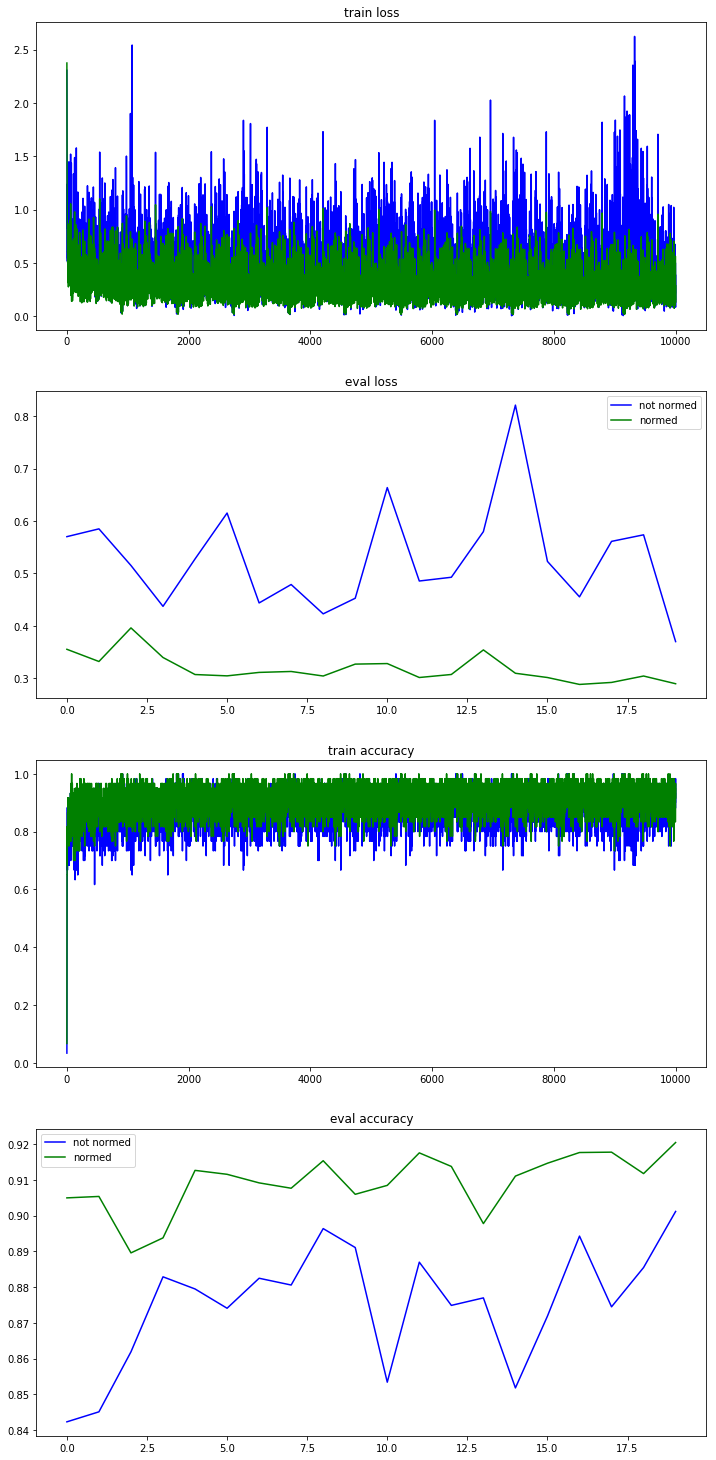

In [192]:
fig, axes = plt.subplots(4, figsize=[12, 26])

axes[0].set_title('train loss')
axes[0].plot(tn_losses_nbn, c='b')
axes[0].plot(tn_losses_bn, c='g')

axes[1].set_title('eval loss')
axes[1].plot(eval_losses_nbn, c='b', label='not normed')
axes[1].plot(eval_losses_bn, c='g', label='normed')
axes[1].legend()

axes[2].set_title('train accuracy')
axes[2].plot(tn_accs_nbn, c='b')
axes[2].plot(tn_accs_bn, c='g')

axes[3].set_title('eval accuracy')
axes[3].plot(eval_accs_nbn, c='b', label='not normed')
axes[3].plot(eval_accs_bn, c='g', label='normed')
axes[3].legend()
